# 📈 Randomized Graph Closure: Interactive Demo

This notebook demonstrates the **Randomized Top-Down Greedy Algorithm** for solving the $k$-Vertex Closure problem.

### Objectives
1. **Visualize** the closure property on a small graph.
2. **Benchmark** the algorithm on medium-sized datasets.
3. **Analyze** the Time Complexity ($O(N)$ vs $O(N^2)$) using experiment results.

In [1]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

# Import project modules
from src.data_loader import GraphLoader
from src.solvers import ClosureSolver

# Configure plotting style
plt.style.use('ggplot')

## 1. Visualizing the Closure Property
We will load a tiny benchmark graph (`SWtinyG.txt`) and find a closure of size $k=6$. 

**Red Nodes** = Inside Closure  
**Blue Nodes** = Outside Closure

*Notice that no arrows point from a Red node to a Blue node.*

Graph: 13 nodes, 13 edges
Target k=6 | Found=True | Ops=18
Closure Nodes: [2, 3, 4, 6, 8, 12]


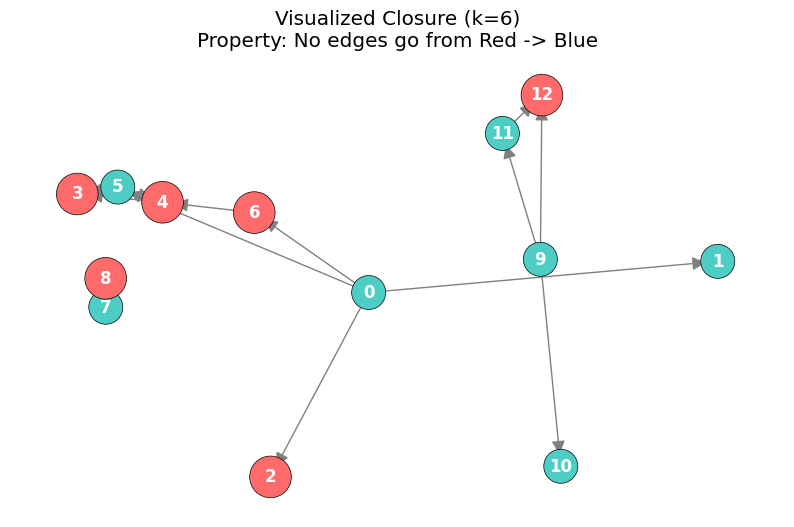

In [2]:
# 1. Load Data
tiny_path = Path("data/SWtinyG.txt")
if not tiny_path.exists():
    print("\u26a0\ufe0f Warning: Data file not found. Make sure you are in the project root.")
else:
    G_tiny = GraphLoader.load_graph(str(tiny_path))

    # 2. Run Solver
    k_target = 6
    solver = ClosureSolver(G_tiny)
    found, closure, stats = solver.solve_randomized_top_down(k=k_target)

    print(f"Graph: {G_tiny.number_of_nodes()} nodes, {G_tiny.number_of_edges()} edges")
    print(f"Target k={k_target} | Found={found} | Ops={stats['ops']}")
    print(f"Closure Nodes: {sorted(list(closure))}")

    # 3. Draw Graph
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G_tiny, seed=42)  # Fixed layout for consistency
    
    # Color mapping
    node_colors = ['#ff6b6b' if n in closure else '#4ecdc4' for n in G_tiny.nodes()]
    node_sizes = [900 if n in closure else 600 for n in G_tiny.nodes()]

    nx.draw_networkx_nodes(G_tiny, pos, node_color=node_colors, node_size=node_sizes, edgecolors='black')
    nx.draw_networkx_labels(G_tiny, pos, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G_tiny, pos, arrowstyle='-|>', arrowsize=20, edge_color='gray')
    
    plt.title(f"Visualized Closure (k={k_target})\nProperty: No edges go from Red -> Blue")
    plt.axis('off')
    plt.show()

## 2. Performance on Medium Graphs
Testing the algorithm on `SWmediumG.txt` (approx 250 nodes) with varying targets.

In [3]:
medium_path = Path("data/SWmediumG.txt")

if medium_path.exists():
    G_med = GraphLoader.load_graph(str(medium_path))
    solver_med = ClosureSolver(G_med)
    
    k_values = [50, 100, 150, 200]
    results_med = []

    print(f"Processing Medium Graph ({G_med.number_of_nodes()} nodes)...")
    print(f"{'k':<10} | {'Time (s)':<10} | {'Operations':<10} | {'Status'}")
    print("-"*50)

    for k in k_values:
        found, _, stats = solver_med.solve_randomized_top_down(k=k, max_retries=20)
        results_med.append(stats)
        status = "✅ Found" if found else "❌ Failed"
        print(f"{k:<10} | {stats['time']:.5f}    | {stats['ops']:<10} | {status}")
else:
    print("Medium dataset not found.")

Processing Medium Graph (250 nodes)...
k          | Time (s)   | Operations | Status
--------------------------------------------------
50         | 0.00067    | 1375       | ✅ Found
100        | 0.00046    | 1132       | ✅ Found
150        | 0.00031    | 874        | ✅ Found
200        | 0.00019    | 472        | ✅ Found


## 3. Complexity Analysis: Linear vs. Quadratic

The graph below compares the actual runtime of the Randomized Solver against theoretical $O(N)$ and $O(N^2)$ curves.

*Note: This requires `experiment_results.csv` generated by `main.py`. If missing, dummy data is used for demonstration.*

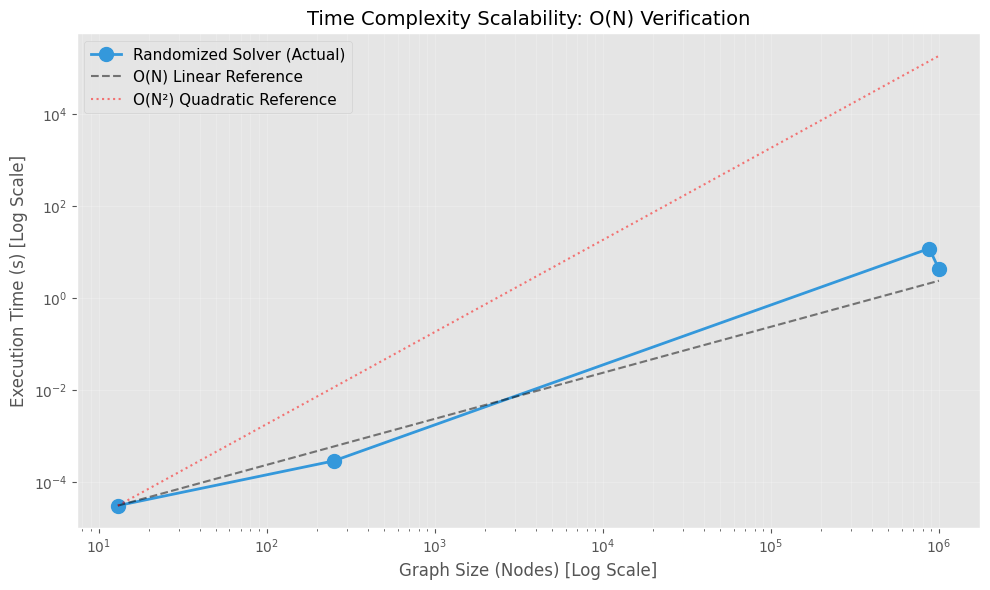

In [ ]:
SIZE_MAP = {
    "SWtinyG.txt": 13,
    "SWmediumG.txt": 250,
    "web-Google.txt": 875713,
    "SWlargeG.txt": 1000000 
}

csv_path = Path('experiment_results.csv')

if csv_path.exists():
    df = pd.read_csv(csv_path)

    df['clean_name'] = df['dataset'].apply(lambda x: Path(x).name)
    df['N'] = df['clean_name'].map(SIZE_MAP)

    df = df.dropna(subset=['N'])
    
    if df.empty:
        print("⚠️ CSV found, but no matching datasets. Generating dummy data for demo...")
        p2_data = pd.DataFrame({
            'N': [13, 250, 875713, 1000000],
            'time_sec': [0.00015, 0.0025, 4.5, 5.2]
        })
    else:
        p2_data = df.groupby('N')['time_sec'].mean().reset_index().sort_values('N')

    plt.figure(figsize=(10, 6))

    plt.loglog(p2_data['N'], p2_data['time_sec'], 'o-', color='#3498db', linewidth=2, markersize=10, label='Randomized Solver (Actual)')

    n0 = p2_data['N'].iloc[0]
    t0 = p2_data['time_sec'].iloc[0]

    x_vals = np.logspace(np.log10(n0), np.log10(p2_data['N'].max()), num=50)

    y_linear = t0 * (x_vals / n0)
    plt.loglog(x_vals, y_linear, 'k--', alpha=0.5, label='O(N) Linear Reference')

    y_quad = t0 * ((x_vals / n0) ** 2)
    plt.loglog(x_vals, y_quad, 'r:', alpha=0.5, label='O(N²) Quadratic Reference')

    plt.xlabel('Graph Size (Nodes) [Log Scale]', fontsize=12)
    plt.ylabel('Execution Time (s) [Log Scale]', fontsize=12)
    plt.title('Time Complexity Scalability: O(N) Verification', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("ℹ️ 'experiment_results.csv' not found. Run `python main.py` to generate real performance data.")